## Stochastic Galerkin for 2D Poisson Equation
Seek solution $u(x,y,\omega)$ that satisfies:
- $\alpha(\omega) (u(x,y,\omega)_{xx} + u(x,y,\omega)_{yy}) = 1$ on $\mathcal{D} \times \Omega$
- $u(x,y,\omega) = 0$ on $\partial \mathcal{D} \times \Omega$

where $\mathcal{D} = \{(x,y): -1 \leq x \leq 1, -1 \leq y \leq 1\}$ is the spatial domain and $\Omega$ is the sample space. Also $\alpha(\omega)$ is a random variable distributed over the interval $[1,3]$.

In [45]:
#Import necessary modules
import numpy as np
from scipy.sparse import diags, csr_matrix, kron
from scipy.linalg import solve_sylvester, schur, expm
from scipy.sparse.linalg import spsolve, cg
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import random
%config InlineBackend.figure_format = 'svg'

In [46]:
def plot_sol(X,Y,U,i):
    plt.figure(i)
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(U, -1)
    plt.imshow(U, extent=[-1,1,-1,1], origin='lower')
    plt.colorbar()
    plt.axis(aspect='image')
    plt.xlabel('x')
    plt.ylabel('y')


def compute_err(U, U_exact):
    n = len(U)
    err_inf = 0
    err_sq = 0
    for i in range(0,n):
        for j in range(0,n):
            err_sq += np.absolute(U_exact[i][j] - U[i][j])**2
            if np.absolute(U_exact[i][j] - U[i][j]) > err_inf:
                err_inf = np.absolute(U_exact[i][j] - U[i][j])
        
    err_sq = (err_sq * h**2)**0.5
    return err_inf, err_sq


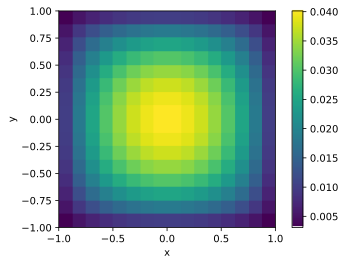

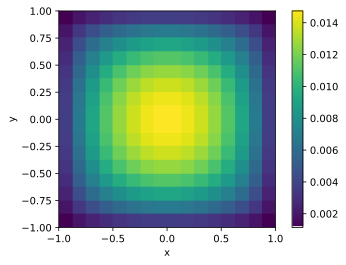

In [36]:
import numpy as np
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve, cg
from scipy.special import legendre
from scipy.integrate import quad
from sympy import *
from scipy import sparse

n = 16 #number of grid points in each spatial direction
h = 1/(n+1) #grid spacing
r = 1 #number of random dimensions
k = 3 #order of PCE
p = int((np.math.factorial(k+r)/np.math.factorial(k)) - 1) #p+1=(k+r)!/k!

def inner_product(i,j,E=False):
    if E==True:
        I = lambda xi: (1/2)*legendre(i,xi)*legendre(j,xi)
    else:
        I = lambda xi: (1/2)*legendre(i,xi)*(xi+2)*legendre(j,xi)
    return quad(I,-1,1)[0]

#Define central differencing operator matrix using five point stencil 
diagonals = [[-2],[1],[1]]
T = np.multiply((-1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())
L = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n))

P = np.zeros([p+1,p+1]) #P is (p+1)*(p+1) matrix with P_ij = <psi_i*(xi+2)*psi_j>
for i in range(0,p+1):
    for j in range(0,p+1):
        P[i][j] = inner_product(i,j)

e = np.ones([n**2]) #Set e as a vector of 1s
f = np.zeros([p+1,n**2]) #Initalise f and set first row = e and reshape
f[0] = e
f = np.reshape(f,-1)

#Compute matrix D and covert to sparse format
D = kron(P,L)
D = sparse.csr_matrix(D)

#Solve system and reshape appropriately
U = spsolve(D,f)
U = np.reshape(U,(p+1,n**2))
mean_u = U[0,:]
mean_u = np.reshape(mean_u,(n,n))

#Compute variance
xi_sq = np.zeros([p+1])
xi_sq[0] = 1
for i in range(1,p+1):
    xi_sq[i] = inner_product(i,i,True)
    
var_u = np.zeros(n**2)
for i in range(0,n**2):
    for j in range(1,p+1):
        var_u[i] += (U[j][i]**2)*(inner_product(j,j)**2)
    var_u[i] = np.sqrt(var_u[i])
var_u = np.reshape(var_u,(n,n))
    

#Define x and y as arrays between -1 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(-1+h, 1-h, n)
y = np.linspace(-1+h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Plot mean and var solutions
plot_sol(X,Y,mean_u,0)
plot_sol(X,Y,var_u,1)

## Monte Carlo (for comparison)

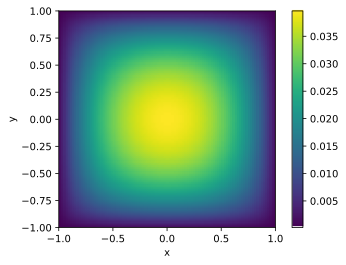

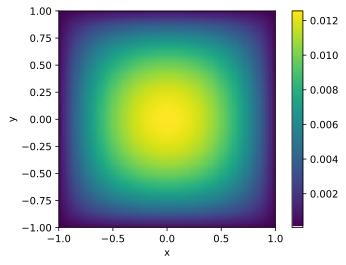

In [196]:
#Import necessary modules
import numpy as np
from scipy.sparse import diags, csr_matrix, kron
from scipy.linalg import solve_sylvester, schur, expm
from scipy.sparse.linalg import spsolve, cg
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import random
%config InlineBackend.figure_format = 'svg'

#Define parameters
n = 100
h = 1/(n+1) #step size

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(-1+h, 1-h, n)
y = np.linspace(-1+h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Define tridiagonal matrix T
diagonals = [[-2],[1],[1]]
T = np.multiply((-1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())
L = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n))
F = np.ones([n**2,1])

M = 100 #number of samples

def monteCarlo(M,L):

    #Define mean, variance and solutions as zero matrices
    mean_sol = np.zeros([n**2])
    var_sol = np.zeros([n**2])
    sols = np.zeros([M,n**2])
    A = np.zeros([n**2,n**2])
        
    for i in range(0, M): 
        xi = random.uniform(-1, 1) #Generate random eps in range(-1,1)
        A = (xi+2)*L
        U = spsolve(A,F)
        mean_sol += U
        sols[i] = U
        
    mean_sol = mean_sol/M #Divide by number of samples to get the mean solution
    
    #Calculate variance
    for i in range(0, M):
        var_sol += ((sols[i] - mean_sol)**2)/(M-1)
    var_sol = np.sqrt(var_sol)
        
    #Reshape and plot solutions
    mean_sol = np.reshape(mean_sol,(n,n))
    var_sol = np.reshape(var_sol,(n,n))
    plot_sol(X,Y,mean_sol,0)
    plot_sol(X,Y,var_sol,1)
        
    

monteCarlo(M,L)








## 1D Heat Equation
$u_t (t,x,\omega) = (\alpha(x,\omega) u_x(t,x,\omega))_x + 1$

where $x \in [-1,1]$, $t \in [0,T]$, $\omega \in \Omega$ with BCs: $u(t,-1,\omega) = u(t,1,\omega)$ and IC: $u(0,x,\omega)=0$

Random field $\alpha$ characterised by mean $\bar{\alpha} = 10$ and covariance $C_\alpha (x_1, x_2) = e^{-|x_1 - x_2|}, \;\;\; x_1, x_2 \in [-1,1]$

Rewrite equation as $u_t = \alpha u_{xx} + \alpha_x u_x + 1$

In [49]:
import numpy as np
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve, cg
from scipy.special import legendre
from scipy.integrate import quad
from sympy import *
from scipy import sparse
from scipy.optimize import newton

n = 20 #number of grid points in space
h = 1/(n+1) #grid spacing
N = 3 #number of random variable in KLE
k = 3 #order of PCE
p = int((np.math.factorial(N+k)/(np.math.factorial(N)*np.math.factorial(k))) - 1) #p+1=(N+k)!/N!k!
print(p)

#Define x as arrays between -1 and 1 with n evenly spaced points
x = np.linspace(-1+h, 1-h, n)

#Function to compute inner product
def inner_product(i,j,E=False):
    if E==True:
        I = lambda xi: (1/2)*legendre(i,xi)*legendre(j,xi)
    else:
        I = lambda xi: (1/2)*legendre(i,xi)*(xi)*legendre(j,xi)
    return quad(I,-1,1)[0]

#Arrays to hold values for calculating eigenpairs
omega = np.zeros(N)
eigv = np.zeros(N)

#Functions for finding roots
def omega_even(w):
    return 1 - w*np.tan(w)

def omega_odd(w):
    return w + np.tan(w)

#Find j roots
for j in range(0,N):
    if j % 2 == 0: #even
        omega[j] = newton(omega_even,j)
    else: #odd
        omega[j] = newton(omega_odd,10+j)
    eigv[j] = 2/((omega[j])**2 + 1)
    
#Even and odd eigenfunctions
def eigf_even(x,j, derv=False):
    if derv == True:
        return -omega[j]*np.sin(omega[j]*x)/(np.sqrt(1 + (np.sin(2*omega[j])/2*omega[j])))
    else:
        return np.cos(omega[j]*x)/(np.sqrt(1 + (np.sin(2*omega[j])/2*omega[j])))

def eigf_odd(x,j, derv=False):
    if derv == True:
        return eigv[j]*np.cos(eigv[j]*x)/(np.sqrt(1 - (np.sin(2*eigv[j])/2*eigv[j])))
    else:
        return np.sin(eigv[j]*x)/(np.sqrt(1 - (np.sin(2*eigv[j])/2*eigv[j])))

#Matrices for 1st and 2nd spatial derivatives
d1 = [[0],[-1],[1]]
L1 = diags(d1, [0, -1, 1], shape=(n, n)).toarray()
d2 = [[-2],[1],[1]]
L2 = diags(d2, [0, -1, 1], shape=(n, n)).toarray()

#Define P^j
P = np.zeros([N,p+1,p+1])
for j in range(0,N):
    for i in range(0,p+1):
        for k in range(0,p+1):
            P[j][i][k] = inner_product(i,k)

#Define E
E = np.zeros([p+1,p+1])
for i in range(0,p+1):
    for j in range(0,p+1):
        if i == j:
            E[i][j] = inner_product(i,j,True)

#Define diagonal matrices for eigenpairs
D_alpha = np.zeros([N,n,n])
D_dalpha = np.zeros([N,n,n])
for j in range(0,N):
    for i in range(0,n):
        for k in range(0,n):
            if i == k:
                if j % 2 == 0: #even j
                    D_alpha[j][i][k] = np.sqrt(eigv[j])*eigf_even(x[i],j)
                    D_dalpha[j][i][k] = np.sqrt(eigv[j])*eigf_even(x[i],j,True)
                else: #odd j
                    D_alpha[j][i][k] = np.sqrt(eigv[j])*eigf_odd(x[i],j)
                    D_dalpha[j][i][k] = np.sqrt(eigv[j])*eigf_odd(x[i],j,True)
                    
#Define F
F = np.zeros([p+1,n])
F[0] = 1

    


19
4
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

## Matrix equation

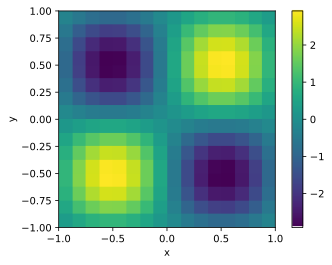

In [54]:
import numpy as np
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve, cg
from scipy.special import legendre
from scipy.integrate import quad
from sympy import *
from scipy import sparse

n = 16 #number of grid points in each spatial direction
h = 1/(n+1) #grid spacing
r = 1 #number of random dimensions
k = 2 #order of PCE
p = int((np.math.factorial(k+r)/np.math.factorial(k)) - 1) #p+1=(k+r)!/k!

#Define x and y as arrays between -1 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(-1+h, 1-h, n)
y = np.linspace(-1+h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

def inner_product(i,j,single=False):
    if single == False:
        I = lambda xi: (1/2)*legendre(i,xi)*legendre(j,xi)
    else:
        I = lambda xi: (1/2)*legendre(i,xi)*xi
    return quad(I,-1,1)[0]

#Define central differencing operator matrix using five point stencil 
diagonals = [[-2],[1],[1]]
T = np.multiply((-1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())
L = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n))

P = np.zeros([p+1,p+1]) #P is (p+1)*(p+1) matrix with P_ij = <psi_i*(xi+2)*psi_j>
for i in range(0,p+1):
    for j in range(0,p+1):
        P[i][j] = inner_product(i,j)

f = np.zeros([p+1,n,n]) #Initalise f and set first row = e and reshape
for i in range(0, p+1):
    for j in range(0, n):
        for k in range(0, n):
            if i == 0: #first row
                f[i][j][k] = inner_product(i,i,True)*34*np.pi**2*np.sin(3*np.pi*x[j])*np.sin(5*np.pi*y[k]) + 25*np.pi**2*np.sin(np.pi*x[j])*np.sin(np.pi*y[k])
            else:
                f[i][j][k] = inner_product(i,i,True)*34*np.pi**2*np.sin(3*np.pi*x[j])*np.sin(5*np.pi*y[k])
            
f = np.reshape(f,(p+1,n**2))
f = np.reshape(f, ((p+1)*n**2))

#Compute matrix D and covert to sparse format
D = kron(P,L)
D = sparse.csr_matrix(D)

#Solve system and reshape appropriately
U = spsolve(D,f)
U = np.reshape(U,(p+1,n**2))
mean_u = U[0,:]
mean_u = np.reshape(mean_u,(n,n))

#Plot mean and var solutions
plot_sol(X,Y,mean_u,0)
